In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
%matplotlib inline

In [2]:
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges.mat')

In [3]:
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)

In [4]:
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["loc","time"],
                        coords=dict(
                            loc=(["loc"], tg_data['ID'][0,:]),
                            time=(["time"], t_rec),
                            lon=(['loc'], tg_data['lon'][0,:]),
                            lat=(['loc'], tg_data['lat'][0,:]),
                        ),        
                       )

In [5]:
# subset for desired years 
t_s = '2008-01-15'
t_e = '2017-12-15'
tg_sub = data_da.sel(time=slice(t_s, t_e))
tg_sub_a = tg_sub - data_da.sel(time=slice(t_s, t_e)).mean(dim='time')

In [6]:
p1_test = tg_sub.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [7]:
tg_obp_trend_a = p1_test # - np.nanmean(p1_test)
print(tg_obp_trend_a.data)

[0.01182159 0.01145987 0.01303731 0.01048055 0.01450867 0.01338044
 0.01274324 0.01204648 0.01351487 0.01365693 0.01022123 0.01256775
 0.01545009 0.01833553 0.02088157 0.02202018 0.01589095 0.01373192
 0.01032021]


In [8]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [75]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN


In [24]:
# Vertical Land Motion 
file = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vertical_velocities_table.txt")
# data = file.readlines()
data = np.loadtxt(file,skiprows=13,usecols=(2,3,4,5,6,7))
file.close()

In [57]:
int(np.where(dist == np.nanmin(dist))[0][0])

440

In [58]:
# find closest distance from gauges of interest 
closest = np.nan*np.ones(len(data_da.lon)); dist_b = np.nan*np.ones(len(data_da.lon)); rate = np.nan*np.ones(len(data_da.lon));
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    dist_x = 1852*60*np.cos(np.deg2rad(sta_lat))*(data[:,0] - sta_lon)
    dist_y = 1852*60*(data[:,1] - sta_lat)
    dist = np.sqrt(dist_x**2 + dist_y**2)
    closest[i] = int(np.where(dist == np.nanmin(dist))[0][0])
    dist_b[i] = dist[int(np.where(dist == np.nanmin(dist))[0][0])]
    rate[i] = data[int(np.where(dist == np.nanmin(dist))[0][0]),4]/100

In [73]:
tg_obp_trend_a = p1_test # - np.nanmean(p1_test)
print(tg_obp_trend_a.data)
print(-1*rate/tg_obp_trend_a.data)
tg_obp_trend_a_mvlm = p1_test.data - (-1)*rate
print(tg_obp_trend_a_mvlm)

[0.01182159 0.01145987 0.01303731 0.01048055 0.01450867 0.01338044
 0.01274324 0.01204648 0.01351487 0.01365693 0.01022123 0.01256775
 0.01545009 0.01833553 0.02088157 0.02202018 0.01589095 0.01373192
 0.01032021]
[ 0.90512358 -0.36649622  0.26079001  0.3244104   0.23434266  0.65767649
  0.14909866  0.15772238  0.31076882  0.3075362   0.41090929  5.2037951
  4.23298603  3.56684498  2.19811033 -0.17711028  2.24656163  2.59978232
  3.4592306 ]
[ 0.00112159  0.01565987  0.00963731  0.00708055  0.01110867  0.00458044
  0.01084324  0.01014648  0.00931487  0.00945693  0.00602123 -0.05283225
 -0.04994991 -0.04706447 -0.02501843  0.02592018 -0.01980905 -0.02196808
 -0.02537979]


In [76]:
# find closest SLA trend (AVISO)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_sl_glo_phy-ssh_my_allsat_l4_pt25deg_P1D_1646240076063_2008_2018.nc'
av = xr.open_dataset(av_path)
av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
avsla = av.sla[av_time_o,:,:]
avsla = avsla-avsla.mean(dim='time')
pavsla = avsla.polyfit(dim='time', deg=1)
# avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
# avsla_detrend = avsla - avsla_trend
aviso_sla_trend = pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

In [83]:
av_lon, av_lat = np.meshgrid(av.longitude.data, av.latitude.data)
aviso_sla_trend_f = aviso_sla_trend.data.flatten()

In [86]:
nb_trend = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    dist_x = 1852*60*np.cos(np.deg2rad(sta_lat))*(av_lon.flatten() - sta_lon)
    dist_y = 1852*60*(av_lat.flatten() - sta_lat)
    dist = np.sqrt(dist_x**2 + dist_y**2)
    nearby_i = np.where(dist <= 25000)
    nb_trend[i] = np.nanmean(aviso_sla_trend_f[nearby_i])

In [117]:
cmap = mpl.cm.get_cmap('viridis')
clow = -0.015
chigh = 0.015
norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_60044/148283059.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(data[np.int(closest[i]),0],data[np.int(closest[i]),1],color='g',s=25,transform=ccrs.PlateCarree(),zorder=2)


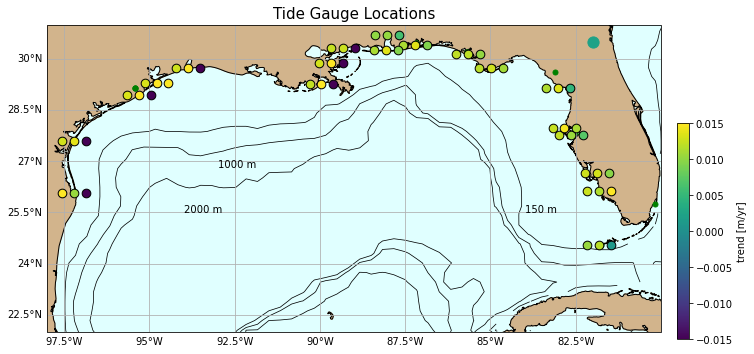

In [119]:
# Locations 
f, ax = plt.subplots(1,1,figsize=(11,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tg_data['lat'][0,:])):
    ax.scatter(data[np.int(closest[i]),0],data[np.int(closest[i]),1],color='g',s=25,transform=ccrs.PlateCarree(),zorder=2)
    ax.scatter(tg_data['lon'][0,i]+0.35,tg_data['lat'][0,i],\
               color=[cmap( (tg_obp_trend_a_mvlm[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    ax.scatter(tg_data['lon'][0,i],tg_data['lat'][0,i],\
               color=[cmap( (tg_obp_trend_a[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    ax.scatter(tg_data['lon'][0,i]-0.35,tg_data['lat'][0,i],\
               color=[cmap( (nb_trend[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.scatter(-82,30.5,color=[cmap( (0.00225 - clow)/(chigh - clow) )],s=125,transform=ccrs.PlateCarree(),zorder=3)
ax.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-84,25.5,'150 m', color='k')
ax.contour(lons,lats,dep,levels=[1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-93,26.8,'1000 m', color='k')
ax.contour(lons,lats,dep,levels=[2000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-94,25.5,'2000 m', color='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([22,31]);
ax.set_title('Tide Gauge Locations',fontsize=15)
cbpos = [0.92, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
ax.set_facecolor('#E0FFFF');
# cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', label=r'depth [m]')
f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label='trend [m/yr]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_tg_locs.jpg', dpi=250)

In [120]:
nb_trend

array([0.01034107, 0.01264219, 0.01273066, 0.0122491 , 0.01237314,
       0.01134915, 0.0118723 , 0.01213805, 0.01113358, 0.01123332,
       0.00998862, 0.01231523, 0.01296707, 0.01219524, 0.01272233,
       0.01314011, 0.01330125, 0.01290779, 0.01494085])